### 4.2 Conversion Models (Raw Factors)

4.2.1 Setup: Libraries, Data, and Functions

All required libraries were imported, and data preprocessing functions were defined. This step included loading the dataset and preparing utilities for model training and evaluation.

4.2.2 Training and Testing Dataset Preparation

The dataset was preprocessed by addressing skewness and applying feature scaling where appropriate. To address class imbalance—since only 13% of observations represented the positive class—the dataset was reduced using undersampling. A stratified sampling method was then applied to create balanced training and testing sets suitable for modeling.

4.2.3 Logistic Regression Model

A logistic regression model was developed for classification. The SHAP analysis revealed that feature f4 had the greatest positive impact on predicting conversion (mean SHAP value = 0.88), followed by f11, which had a negative impact (mean SHAP value = 0.24).

4.2.4 LGBM Model

A LightGBM model was trained, and SHAP analysis again identified f4 as the most influential feature (mean SHAP value = 0.60), followed by f6 (mean = 0.07). The remaining features contributed less, with decreasing mean SHAP values.

4.2.5 Neural Network Model

The neural network model showed consistent patterns. Feature f4 was again the most significant contributor (mean SHAP value = 0.17), followed by f11 (mean = 0.05), with the direction of impact aligning with the previous models.

4.2.6 Conversion Proportions by f4 and f11

To support the model findings, conversion rates were analyzed across binned values of f4 and f11. The analysis showed that lower values of f4 (particularly its mode, which represented ~70% of the data) were associated with lower conversion rates, while higher values were linked to increased conversions. In contrast, f11 had a negative association with conversion: ~85% of observations had the mode (and maximum) value of f11, and users with lower f11 values were more likely to convert.

Summary

All models achieved F1 scores and accuracy in the low to mid 70% range, which is acceptable for behavioral prediction tasks such as conversion modeling. Feature f4 emerged as the most impactful across all models, consistently showing a positive relationship with conversion likelihood. Feature f11 was also influential, especially in the regression and neural network models, and demonstrated an inverse relationship with the outcome. These results reinforce the behavioral nature of the task, where most users share similar characteristics (e.g., dominant modes in f4 and f11), and only subsets deviate in ways that drive conversion.

4.2.1 Setup:  Libraries, Data, and Functions

In [ ]:
# Install libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install umap-learn
!pip install shap
!pip install optuna
!pip install xgboost
!pip install lightgbm
!pip install scipy
!pip install catboost
pip install tensorflow

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import skew
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import optuna
import xgboost as xgb
from statistics import mode
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Sample upload of data
# Saved from previous notebook
df_raw=pd.read_csv('raw_data.csv')

In [ ]:
# Create Stratified Sample

def get_stratified_sample_df(df, target_col, sample_frac=0.1, random_state=42):
  df_sample, _ =train_test_split(df, train_size=sample_frac, stratify=df[target_col], random_state=random_state)
  return df_sample.reset_index(drop=True)

# Create reduced sample for unbalanced data set
def split_data_rus(df, y_colname):
    df = df.copy()
    y=df[y_colname]
    X=df.drop(y_colname,axis=1)
    X_cols=X.columns
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    X_res=pd.DataFrame(X_res, columns=X_cols)
    y_res=pd.DataFrame(y_res, columns=[y_colname])
    df_res=pd.concat([X_res, y_res], axis=1)
    return df_res


In [ ]:
# Divide data into training and testing sets
# Correct skew on columns with skew > 0.5
# Scale factors for training and testing data sets

def split_data(df, y_colname, optional=None):
    df = df.copy()
    y = df[y_colname]
    X = df.drop(y_colname, axis=1)
    X_cols = X.columns

    # Preserve categorical columns
    cat_cols = X.select_dtypes(include='category').columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Handle skew only for numeric
    skewed_cols = X_train[num_cols].apply(skew).sort_values(ascending=False)
    high_skew_cols = skewed_cols[abs(skewed_cols) > 0.5].index.tolist()

    if high_skew_cols:
      pt = PowerTransformer(method='yeo-johnson')
      X_train_skewed = pt.fit_transform(X_train[high_skew_cols])
      X_test_skewed = pt.transform(X_test[high_skew_cols])
      X_train.loc[:, high_skew_cols] = X_train_skewed
      X_test.loc[:, high_skew_cols] = X_test_skewed
    else:
      pass

    # Scale numeric only
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    optional_scaled = None
    opt_y = None
    if optional is not None:
        opt_y = optional[y_colname]
        opt_X = optional.drop(y_colname, axis=1)
        opt_X[high_skew_cols] = pt.transform(opt_X[high_skew_cols])
        opt_X[num_cols] = scaler.transform(opt_X[num_cols])
        optional_scaled = opt_X

    return X_train, X_test, y_train, y_test, optional_scaled, opt_y

In [ ]:
#  Classification Regression Tuning Model

def randomized_logreg_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42, param_dist=None):

  if param_dist is None:
    param_dist = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced', None]
    }
  logreg = LogisticRegression(random_state=random_state)
  f1_pos=make_scorer(f1_score, pos_label=1)
  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
  random_search = RandomizedSearchCV(
      estimator=logreg,
      param_distributions=param_dist,
      n_iter=n_iter,
      cv=skf,
      scoring=f1_pos,
      verbose=1,
      n_jobs=-1,
      random_state=random_state
  )

  random_search.fit(X_train, y_train)
  best_logreg = random_search.best_estimator_
  y_pred = best_logreg.predict(X_test)
  print("Best Parameters:", random_search.best_params_)
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix (Best Logistic Regression)')
  plt.show()

  return best_logreg

In [ ]:
#  LGBM Tuning model

def randomized_lgbm_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42, param_dist=None):

    if param_dist is None:
        param_dist = {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [3,4,5,6],
            'learning_rate': [0.05, 0.1, 0.2],
            'num_leaves': [15,31,36]
        }


    lgbm = LGBMClassifier(
        class_weight='balanced',
        random_state=random_state
    )

    f1_pos=make_scorer(f1_score, pos_label=1)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_dist,
        n_iter=n_iter if isinstance(param_dist, dict) else 1,
        cv=skf,
        scoring=f1_pos,
        verbose=1,
        n_jobs=-1,
        random_state=random_state
    )


    random_search.fit(X_train, y_train)
    best_lgbm = random_search.best_estimator_

    # Evaluation
    y_pred = best_lgbm.predict(X_test)
    print("Best Parameters:", random_search.best_params_)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Best LightGBM)')
    plt.show()

    return best_lgbm

In [ ]:
# LGBM SHAP function

def shap_plot(model, X_train, X_test, y_train, y_test):
    # Convert categorical columns to 'category' dtype in X_test for SHAP plotting
    for col in X_train.select_dtypes(include='category').columns:
        X_test[col] = X_test[col].astype('category')

    # Fit the model
    model.fit(X_train, y_train)

    booster=model.booster_

    # Initialize the explainer directly with the model and training data
    # SHAP will handle extracting the necessary components from the LGBMClassifier object
    explainer = shap.TreeExplainer(booster)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X_test)

    # Determine base value and SHAP values for the positive class (class 1)
    if isinstance(shap_values, list):  # Binary classification
        shap_values_class1 = shap_values[1]
        base_value = explainer.expected_value[1]
    else: # Regression or other cases where shap_values is a single array
        shap_values_class1 = shap_values
        base_value = explainer.expected_value


    # Create SHAP explanation object
    explanation = shap.Explanation(
        values=shap_values_class1,
        base_values=np.full(shap_values_class1.shape[0], base_value),
        data=X_test,
        feature_names=X_test.columns
    )

    # Generate SHAP plots
    shap.plots.beeswarm(explanation)
    shap.plots.bar(explanation)
    shap.dependence_plot('f4', shap_values_class1, X_test)

# Regression SHAP function

def shap_plot_reg(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  explainer = shap.LinearExplainer(model, X_train, feature_peturbation='interventional')
  shap_values = explainer(X_test)

  if isinstance(shap_values,list) and len(shap_values)==2:
    shap_values_class1=shap_values[1]
  else:
    shap_values_class1 = shap_values

  shap.plots.beeswarm(shap_values)
  shap.plots.bar(shap_values)

4.2.2 Create Training and Testing Datasets

In [ ]:
# Remove unnecessary columns, reduce sample size

df=df_raw.copy()
df=df[df['exposure']==1].reset_index(drop=True)
df=df.drop(['treatment','exposure'], axis=1)
sample=split_data_rus(df, 'conversion')
sample=get_stratified_sample_df(sample, 'conversion', sample_frac=0.2)
sample.shape

(9186, 13)

In [ ]:
# Correct skew, split data, scale data

X_train, X_test, y_train, y_test, optional_scaled, opt_y=split_data(sample,'conversion')

4.2.3  Classification Regression Model

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 0.01}

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       919
           1       0.77      0.69      0.73       919

    accuracy                           0.74      1838
   macro avg       0.74      0.74      0.74      1838
weighted avg       0.74      0.74      0.74      1838



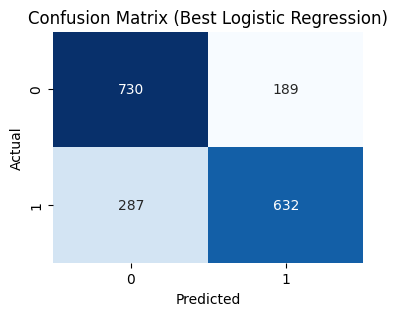

In [ ]:
# Create Regression Model
best_logreg_all=randomized_logreg_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42)

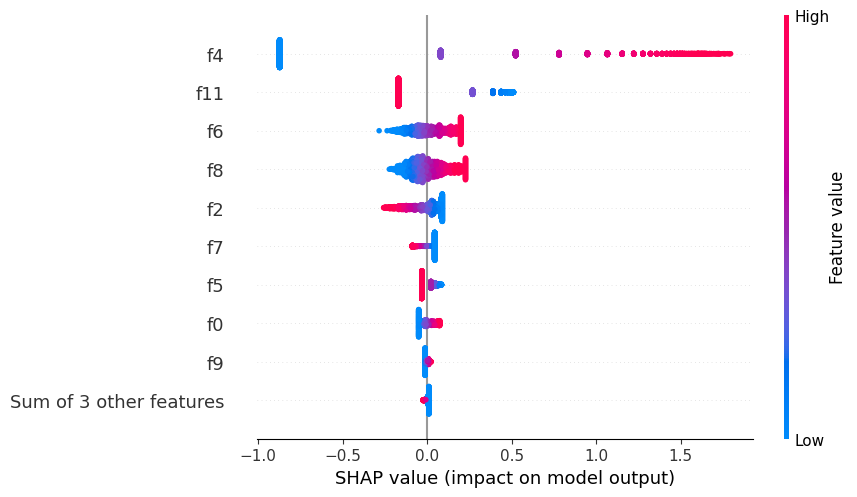

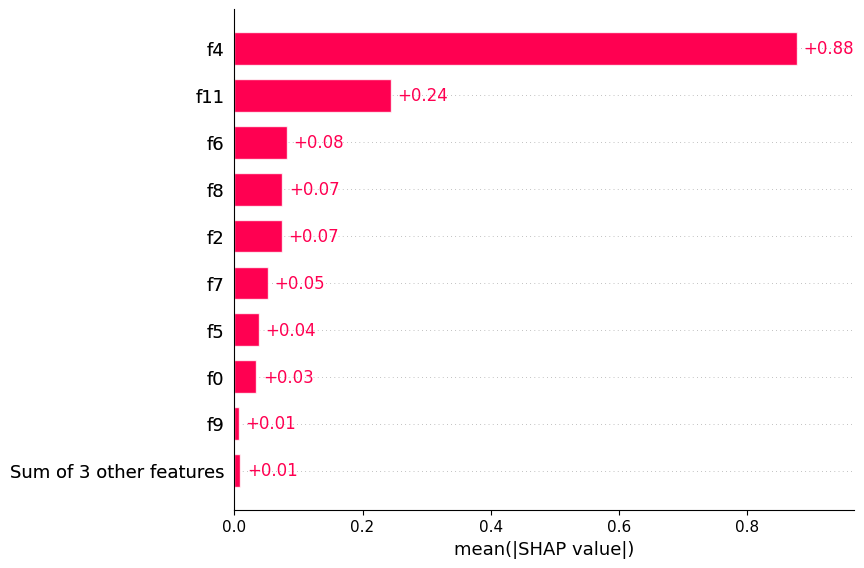

In [ ]:
# SHAP plots of regression model
shap_plot_reg(best_logreg_all, X_train, X_test, y_train, y_test)

Regression Conclusions:
f4 has the greatest influence on conversion, with a mean shap value of 0.88.  There is also inverse influence from f11.  The remaining factors have less significance.

4.2.4 LGBM Model

In [ ]:
# Determine parameter range for LGBM model

def objective(trial):
    # Hyperparameter suggestions
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_categorical('max_depth', [-1, 3, 5, 7, 10, 15])
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    min_split_gain = trial.suggest_float('min_split_gain', 0.0, 0.2)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)

    # Constraint 1: num_leaves should not greatly exceed 2^max_depth
    if max_depth > 0:
        max_allowed_leaves = 2 ** max_depth
        if num_leaves > max_allowed_leaves:
            raise optuna.exceptions.TrialPruned()

    # Constraint 2: Avoid too many estimators with low learning rate
    if learning_rate < 0.01 and n_estimators > 600:
        raise optuna.exceptions.TrialPruned()

    # Get categorical column names
    cat_cols = X_train.select_dtypes(include='category').columns.tolist()

    # Define model
    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_split_gain=min_split_gain,
        random_state=42,
        #class_weight='balanced'

    )

    # Use F1 for positive class
    f1_pos = make_scorer(f1_score, pos_label=1)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Cross-validation
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=skf,
        scoring=f1_pos,
        return_train_score=False
    )

    return scores['test_score'].mean()

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params_lgbm = study.best_params

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_params_lgbm

{'n_estimators': 460,
 'max_depth': -1,
 'learning_rate': 0.0020092708654233745,
 'subsample': 0.7998542938319828,
 'colsample_bytree': 0.9894650999628667,
 'num_leaves': 79,
 'min_child_samples': 81,
 'min_split_gain': 0.12523330356102125,
 'scale_pos_weight': 1}

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3674, number of negative: 3674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 7348, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters: {'scale_pos_weight': 1, 'num_leaves': 79, 'n_estimators': 460, 'max_depth': -1, 'learning_rate': 0.002}

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       919
           1       0.77      0.67      0.71       919

    accuracy                           0.73      1838
   macro avg       0.74      0.73      0.73      1838
weighted avg       0.74      0.73      0.73      1838



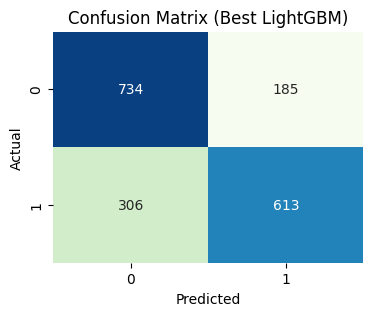

In [ ]:
# Use best parameters in lgbm model
param_dist = {
            'n_estimators': [460],
            'max_depth': [-1],
            'learning_rate': [.002],
            'num_leaves': [79],
            'scale_pos_weight': [1]
        }

best_lgbm=randomized_lgbm_search(X_train, X_test, y_train, y_test, n_iter=20, cv=3, random_state=42, param_dist=param_dist)


[LightGBM] [Info] Number of positive: 3674, number of negative: 3674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1567
[LightGBM] [Info] Number of data points in the train set: 7348, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


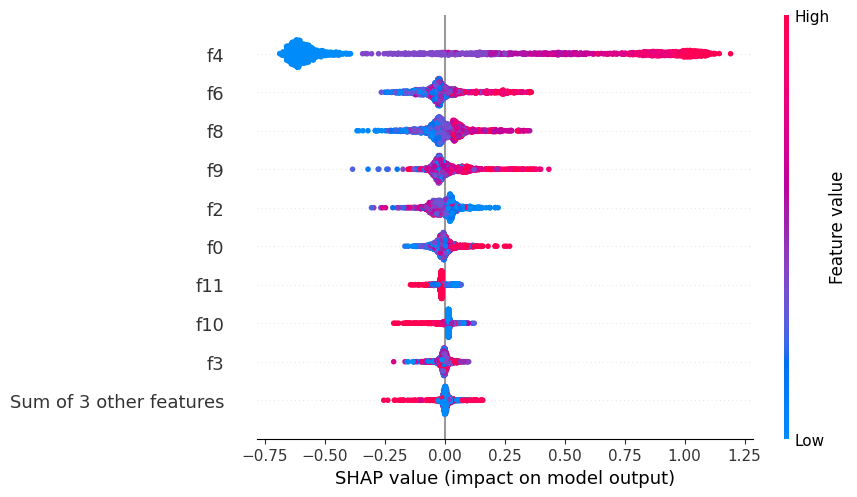

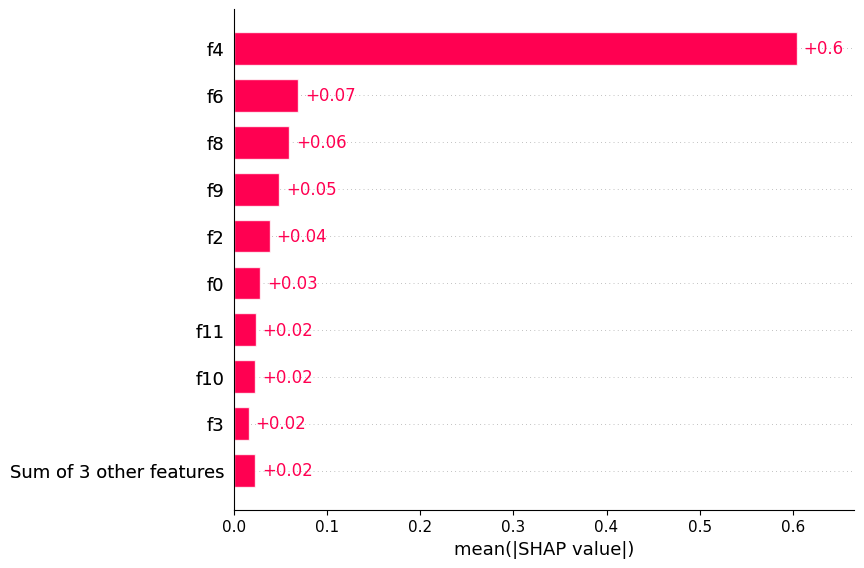

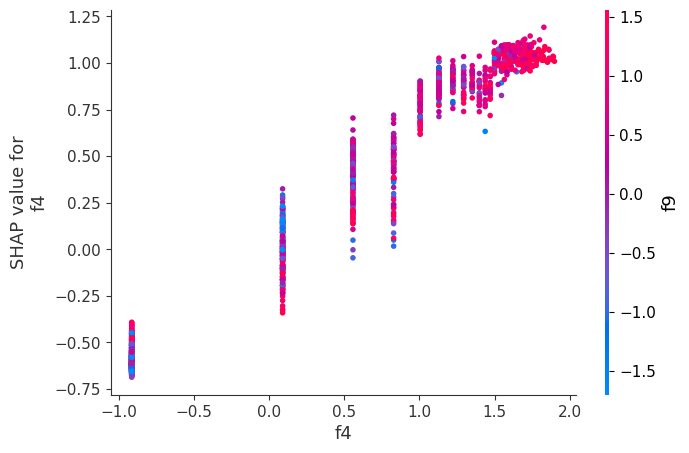

In [ ]:
# SHAP plots of lgbm model
shap_plot(best_lgbm, X_train, X_test, y_train, y_test)

LGBM Conclusions:

The LGBM model is dominated by f4, with a mean of 0.6, the next highest being f6 at 0.07.  It appears that low values of f4 are likely to not convert, and as f4 increases, conversion is more likely.

4.2.5 Neural Network Model

Neural Network Summary:  Similar trends are observed for the neural network model; similar model metrics, and feature importance trends.

In [ ]:
#  Tune neural network parameters
def create_model(trial, input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    # Tune number of hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        units = trial.suggest_int(f'units_{i}', 32, 128, step=32)
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.2, 0.5)
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune learning rate
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy')
    return model

In [ ]:
from tensorflow.keras import backend as K
def objective(trial):
    f1_scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = create_model(trial, X_tr.shape[1])

        # Handle class imbalance
        class_weight = {0: 1.0, 1: len(y_tr[y_tr == 0]) / len(y_tr[y_tr == 1])}

        model.fit(X_tr, y_tr,
                  epochs=20,
                  batch_size=32,
                  verbose=0,
                  class_weight=class_weight)

        y_pred = model.predict(X_val).ravel()
        y_pred_binary = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_binary, pos_label=1)
        f1_scores.append(f1)

        # Clear session to avoid memory buildup
        K.clear_session()

    return np.mean(f1_scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-05-19 18:12:31,380] A new study created in memory with name: no-name-925f5d97-479f-45e6-b0c2-12e3dc6734fe


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-19 18:13:20,156] Trial 0 finished with value: 0.7127681684658111 and parameters: {'n_layers': 3, 'units_0': 128, 'dropout_0': 0.3012509434527556, 'units_1': 128, 'dropout_1': 0.3603984174403632, 'units_2': 128, 'dropout_2': 0.4112203761473052, 'learning_rate': 0.00018235784671314604}. Best is trial 0 with value: 0.7127681684658111.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:13:58,401] Trial 1 finished with value: 0.7096229166576343 and parameters: {'n_layers': 2, 'units_0': 32, 'dropout_0': 0.3654129946109863, 'units_1': 64, 'dropout_1': 0.3244769318550273, 'learning_rate': 0.0012739600052590863}. Best is trial 0 with value: 0.7127681684658111.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:14:37,937] Trial 2 finished with value: 0.7107101069395608 and parameters: {'n_layers': 2, 'units_0': 64, 'dropout_0': 0.21683515651147106, 'units_1': 64, 'dropout_1': 0.20864692747089908, 'learning_rate': 0.0018490420888425787}. Best is trial 0 with value: 0.7127681684658111.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:15:06,512] Trial 3 finished with value: 0.7129042558421435 and parameters: {'n_layers': 1, 'units_0': 32, 'dropout_0': 0.2381642866339097, 'learning_rate': 0.0007381468280513235}. Best is trial 3 with value: 0.7129042558421435.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-19 18:15:47,780] Trial 4 finished with value: 0.70900438198519 and parameters: {'n_layers': 3, 'units_0': 32, 'dropout_0': 0.26401498517277916, 'units_1': 64, 'dropout_1': 0.3584537546879578, 'units_2': 32, 'dropout_2': 0.21558723704764612, 'learning_rate': 0.00019021110591529905}. Best is trial 3 with value: 0.7129042558421435.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:16:18,607] Trial 5 finished with value: 0.7107940974507643 and parameters: {'n_layers': 1, 'units_0': 64, 'dropout_0': 0.4803405072940639, 'learning_rate': 0.0033358454277334342}. Best is trial 3 with value: 0.7129042558421435.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:16:50,707] Trial 6 finished with value: 0.713520560527947 and parameters: {'n_layers': 1, 'units_0': 96, 'dropout_0': 0.393245873010888, 'learning_rate': 0.001057634511670268}. Best is trial 6 with value: 0.713520560527947.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:17:21,282] Trial 7 finished with value: 0.7153834012614646 and parameters: {'n_layers': 1, 'units_0': 96, 'dropout_0': 0.38359853272864897, 'learning_rate': 0.0012912089815693023}. Best is trial 7 with value: 0.7153834012614646.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:18:02,901] Trial 8 finished with value: 0.7062356669507159 and parameters: {'n_layers': 2, 'units_0': 128, 'dropout_0': 0.3612979621568109, 'units_1': 128, 'dropout_1': 0.27006711133497896, 'learning_rate': 0.0009845903589134613}. Best is trial 7 with value: 0.7153834012614646.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:18:44,174] Trial 9 finished with value: 0.706553248792046 and parameters: {'n_layers': 3, 'units_0': 64, 'dropout_0': 0.2066623021781116, 'units_1': 96, 'dropout_1': 0.3384120106416757, 'units_2': 32, 'dropout_2': 0.45091855734915703, 'learning_rate': 0.0067390676920840884}. Best is trial 7 with value: 0.7153834012614646.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:19:19,002] Trial 10 finished with value: 0.7143493933261503 and parameters: {'n_layers': 1, 'units_0': 96, 'dropout_0': 0.45179540808210095, 'learning_rate': 0.0004078563815793135}. Best is trial 7 with value: 0.7153834012614646.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:19:51,893] Trial 11 finished with value: 0.7148510698844994 and parameters: {'n_layers': 1, 'units_0': 96, 'dropout_0': 0.44537986613081776, 'learning_rate': 0.0003539606982044538}. Best is trial 7 with value: 0.7153834012614646.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:20:26,802] Trial 12 finished with value: 0.7121208002276131 and parameters: {'n_layers': 1, 'units_0': 96, 'dropout_0': 0.4257179906076759, 'learning_rate': 0.00047854805153442156}. Best is trial 7 with value: 0.7153834012614646.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:20:57,209] Trial 13 finished with value: 0.7155176745806558 and parameters: {'n_layers': 1, 'units_0': 96, 'dropout_0': 0.49412827371788537, 'learning_rate': 0.00029608323277084507}. Best is trial 13 with value: 0.7155176745806558.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:21:37,991] Trial 14 finished with value: 0.7093877063321207 and parameters: {'n_layers': 2, 'units_0': 128, 'dropout_0': 0.4876009218702162, 'units_1': 32, 'dropout_1': 0.4933257709725507, 'learning_rate': 0.002661363043530691}. Best is trial 13 with value: 0.7155176745806558.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:22:17,964] Trial 15 finished with value: 0.6898083950966948 and parameters: {'n_layers': 2, 'units_0': 96, 'dropout_0': 0.3290797046667725, 'units_1': 32, 'dropout_1': 0.4906703427714122, 'learning_rate': 0.009843554319417927}. Best is trial 13 with value: 0.7155176745806558.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:22:49,183] Trial 16 finished with value: 0.7134145690030476 and parameters: {'n_layers': 1, 'units_0': 64, 'dropout_0': 0.4012505389565891, 'learning_rate': 0.00012956552597647583}. Best is trial 13 with value: 0.7155176745806558.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:23:20,495] Trial 17 finished with value: 0.7139460281333472 and parameters: {'n_layers': 1, 'units_0': 128, 'dropout_0': 0.3053085295760586, 'learning_rate': 0.00029161877373061983}. Best is trial 13 with value: 0.7155176745806558.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:23:54,139] Trial 18 finished with value: 0.7125373644964229 and parameters: {'n_layers': 1, 'units_0': 96, 'dropout_0': 0.39841787119801075, 'learning_rate': 0.0006042337339389215}. Best is trial 13 with value: 0.7155176745806558.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-19 18:24:33,686] Trial 19 finished with value: 0.7042991172266939 and parameters: {'n_layers': 2, 'units_0': 64, 'dropout_0': 0.49280159812830643, 'units_1': 96, 'dropout_1': 0.4164288646489767, 'learning_rate': 0.0037768167617731737}. Best is trial 13 with value: 0.7155176745806558.


In [ ]:
print("Best trial:")
print(f"Value: {study.best_value}")
print("Params:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Best trial:
Value: 0.7155176745806558
Params:
  n_layers: 1
  units_0: 96
  dropout_0: 0.49412827371788537
  learning_rate: 0.00029608323277084507


In [ ]:
# Use tuned parameters in neural network model

class_weight = {0: 1.0, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}
final_model = create_model(study.best_trial, X_train.shape[1])

final_model.fit(X_train, y_train,
                epochs=20,
                batch_size=32,
                class_weight=class_weight,
                verbose=1)

# Evaluate on test set
y_pred_test = (final_model.predict(X_test) > 0.5).astype("int32")
print("\nFinal F1 Score (positive class):", f1_score(y_test, y_pred_test, pos_label=1))

Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7062
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5975
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5872
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5679
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5617
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5782
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5745
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5653
Epoch 9/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5655
Epoch 10/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5624
Epoch 11/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5593
Epoch 12/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5692
Epoch 13/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5585
Epoch 14/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5566
Epoch 15/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo


NN Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       919
           1       0.77      0.70      0.73       919

    accuracy                           0.74      1838
   macro avg       0.75      0.74      0.74      1838
weighted avg       0.75      0.74      0.74      1838



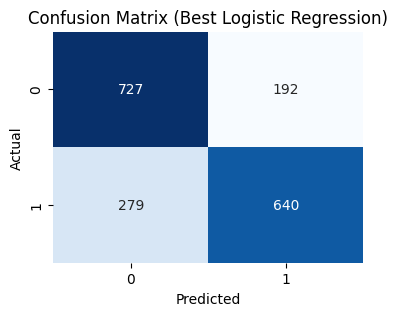

In [ ]:
  print("\nNN Classification Report:")
  print(classification_report(y_test, y_pred_test))

  cm = confusion_matrix(y_test, y_pred_test)
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix (Best Logistic Regression)')
  plt.show()

In [ ]:
# Neural Network SHAP Plots formula
def shap_plot_nn(model, X_train, X_test, max_samples=100, feature_names=None):
    if not isinstance(X_test, pd.DataFrame):
        if feature_names is None:
             print("Warning: feature_names not provided and X_test is not a DataFrame. SHAP plots will show numerical indices.")
             feature_names = [str(i) for i in range(X_test.shape[1])]
        X_test_df = pd.DataFrame(X_test, columns=feature_names)
    else:
        feature_names = X_test.columns.tolist()
        X_test_df = X_test

    X_sample_df = shap.sample(X_test_df, max_samples, random_state=42)
    X_sample_np = X_sample_df.values
    X_train_sample_np = shap.sample(X_train, max_samples, random_state=42).values if isinstance(X_train, pd.DataFrame) else shap.sample(X_train, max_samples, random_state=42)

    if not isinstance(X_train_sample_np, np.ndarray):
        X_train_sample_np = np.array(X_train_sample_np)

    if not isinstance(X_sample_np, np.ndarray):
         X_sample_np = np.array(X_sample_np)


    explainer = shap.DeepExplainer(model, X_train_sample_np)
    shap_values = explainer.shap_values(X_sample_np)

    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_values = shap_values[1]

    if shap_values.ndim > 2:
        if shap_values.shape[2] == 1:
             shap_values = np.squeeze(shap_values, axis=2)
        else:
             print(f"Unexpected SHAP values shape: {shap_values.shape}. Cannot reshape to 2D.")
             return
    elif shap_values.ndim == 1:

        shap_values = shap_values.reshape(-1, 1)

    shap.plots.beeswarm(shap.Explanation(values=shap_values, data=X_sample_np, feature_names=feature_names))
    shap.plots.bar(shap.Explanation(values=shap_values, data=X_sample_np, feature_names=feature_names))

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=['Tensor(shape=(100, 12))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=['Tensor(shape=(200, 12))']
  warnings.warn(msg)


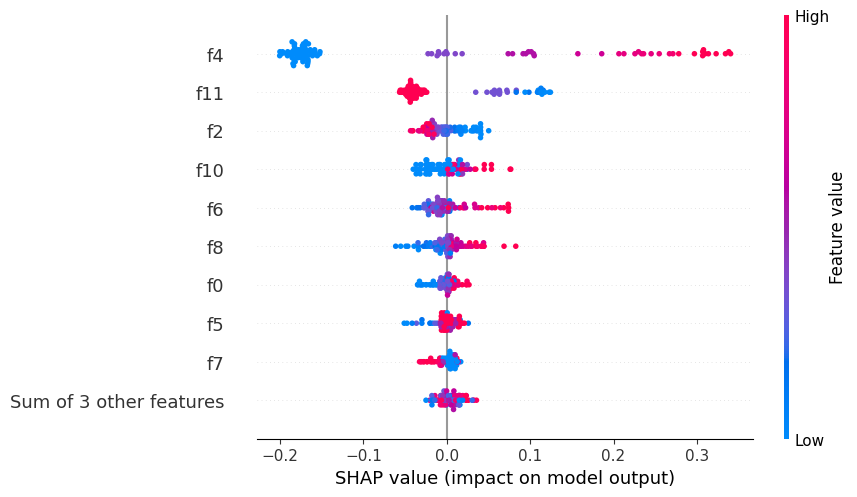

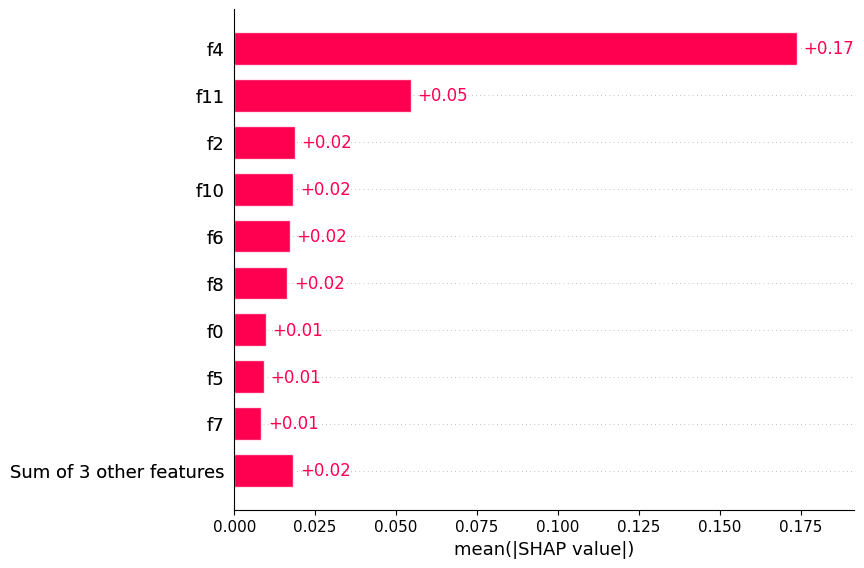

In [ ]:
# SHAP plots of neural network model
shap_plot_nn(final_model, X_train, X_test, max_samples=100, feature_names=X_train.columns)

Neural Network Summary:

Similarly to the other models, it appears that f4 has the greatest influence on conversion.  There is also inverse influence in this model from f11.

4.2.6  f4 and f11 Conversion Proportions

In [ ]:
#  Determine ratios of f4 and f11 to conversion

df_test=df_raw.copy()
df_test=df_test[df_test['exposure']==1].reset_index(drop=True)
df_test=df_test.drop(['treatment','exposure'], axis=1)

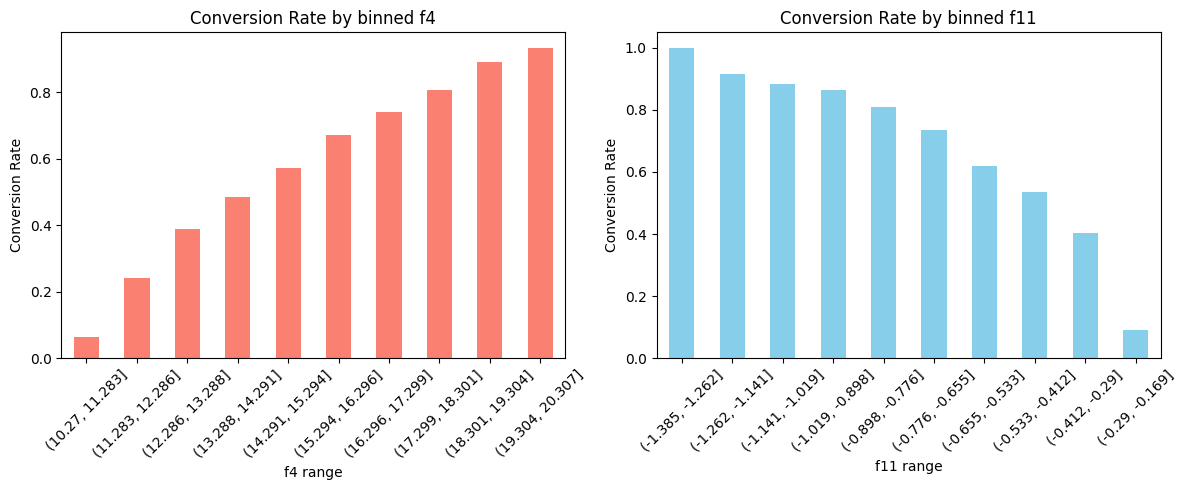

In [ ]:
# Define number of bins
n_bins = 10

# Bin f4 and f11
df_test['f4_bin'] = pd.cut(df_test['f4'], bins=n_bins)
df_test['f11_bin'] = pd.cut(df_test['f11'], bins=n_bins)

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Conversion rate by f4 bins
conv_rate_f4 = df_test.groupby('f4_bin', observed=True)['conversion'].mean()
conv_rate_f4.plot(kind='bar', color='salmon', ax=axes[0])
axes[0].set_title('Conversion Rate by binned f4')
axes[0].set_xlabel('f4 range')
axes[0].set_ylabel('Conversion Rate')
axes[0].tick_params(axis='x', rotation=45)

# Conversion rate by f11 bins
conv_rate_f11 = df_test.groupby('f11_bin', observed=True)['conversion'].mean()
conv_rate_f11.plot(kind='bar', color='skyblue', ax=axes[1])
axes[1].set_title('Conversion Rate by binned f11')
axes[1].set_xlabel('f11 range')
axes[1].set_ylabel('Conversion Rate')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()